In [2]:
import tqdm
import numpy as np
import pandas as pd
import os
import random
from random import randint
import math
import cv2

import tensorflow as tf
from tensorflow.keras import Model, optimizers
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, BatchNormalization, concatenate, Activation, Add
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import Binarizer
from sklearn.model_selection import train_test_split

import plotly.offline as ply
import plotly.graph_objs as graphs
import matplotlib as mpl
import matplotlib.pyplot as plt

# Might be needed to enable GPU
physical_devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
# Load data

project_path = r"C:\Users\cspielvogel\Documents\Python Scripts\data-science-bowl-2018\stage1_train"

images = []
masks = []

for sample_folder in tqdm.tqdm(os.listdir(project_path)):    
    # Original images
    image_folder_path = os.path.join(os.path.join(project_path, sample_folder), "images")
    image_name = os.listdir(image_folder_path)
    if len(image_name) > 1:
        print(image_folder_path, len(image_name))
    image_path = os.path.join(image_folder_path, image_name[0])
    image = cv2.imread(image_path, 0)
    image_isometric = cv2.resize(image, (101, 101))
    images.append(image_isometric)
    
    mask_folder_path = os.path.join(os.path.join(project_path, sample_folder), "masks")
    mask_paths = [os.path.join(mask_folder_path, mask) for mask in os.listdir(mask_folder_path)]
    single_masks = np.array([cv2.imread(mask, 0) for mask in mask_paths])
    mask = ((np.sum(single_masks, axis=0) > 0) * 1).astype('float32')
    mask_isometric = cv2.resize(mask, (101, 101))
    masks.append(mask_isometric)    

100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:46<00:00, 14.50it/s]


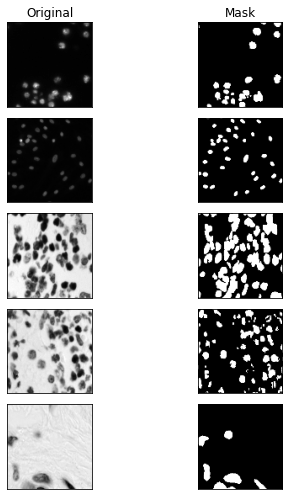

In [4]:
# Visualizing some samples with segmentation
num_samples = 5
shift = 0 # To plot other samples
fig, ax = plt.subplots(num_samples, 2, figsize=(7, 7))
params = {"top": False, "bottom": False, "left": False, "right": False, "labelleft": False,
          "labelbottom": False}

# Set column label color
mpl.rcParams["axes.labelcolor"] = "white"

ax[0, 0].title.set_text("Original")
ax[0, 1].title.set_text("Mask")

for i in range(0, num_samples):
    ax[i, 0].imshow(images[i+shift], cmap="gray")
    ax[i, 0].tick_params(**params)
    ax[i, 1].imshow(masks[i+shift], cmap="gray")
    ax[i, 1].tick_params(**params)

plt.tight_layout()
plt.show()

In [6]:
# Seeding random number generators to obtain reproducible results
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value) # Resets itself on every use!
tf.random.set_seed(seed_value)

In [7]:
def plot_train_val_performance(train_summary, metric="accuracy", show=True):
    """Plot training vs. testing performance over all epochs"""
    
    # Get epochwise performances
    train_metric = train_summary.history[metric]
    val_metric = train_summary.history["val_{}".format(metric)]

    # Format and store performances per epoch for plotting
    performances = {epoch: [round(performance[0], 2), round(performance[1], 2)]
                   for epoch, performance in enumerate(zip(train_metric, val_metric))}
    
    x = list(performances.keys())     # Number of epoch
    y_train = [i[0] for i in performances.values()]
    y_test = [i[1] for i in performances.values()]

    trace_train = graphs.Scatter(x=x, y=y_train, name="Training", mode="lines+markers",
                                 line=dict(width=4),
                                 marker=dict(symbol="circle",
                                             size=10))
    trace_test = graphs.Scatter(x=x, y=y_test, name="Validation", mode="lines+markers",
                                line=dict(width=4),
                                marker=dict(symbol="circle",
                                            size=10))

    layout = graphs.Layout(title="Training vs. validation {}".format(metric),
                           xaxis={"title": "Epoch"},
                           yaxis={"title": metric})

    fig = graphs.Figure(data=[trace_train, trace_test], layout=layout)
    ply.plot(fig, filename="plotly_train_val_{}_unet.html".format(metric), auto_open=show)
    print("Plot saved as plotly_train_val_{}_unet.html".format(metric))

In [8]:
# Set hyperparameters
num_epochs = 100
batch_size = 16
img_size_target = images[0].shape[0]

val_data_ratio = 0.15
test_data_ratio = 0.15

In [9]:
train_imgs, test_imgs, train_masks, test_masks = train_test_split(images, masks, test_size=test_data_ratio)

# Simple Augmentation
train_imgs = np.append(train_imgs, [np.fliplr(x) for x in train_imgs], axis=0)
train_masks = np.append(train_masks, [np.fliplr(x) for x in train_masks], axis=0)

In [10]:
def iou1class(y_true, y_pred, threshold=0.5):
    ious = []
    for component1, component2 in zip(y_true, y_pred):
        component1 = component1.flatten()
        component2 = (component2.flatten() > threshold) * 1
        overlap = component1 * component2
        union = ((component1 + component2) > 0) * 1
        if (component1 == 0).all() and (component2 == 0).all():
            ious.append(1)
        else:
            ious.append(overlap.sum()/float(union.sum()))

    return np.mean(ious).astype(np.float32)

def IoU(y_true, y_pred):    
    iou = tf.numpy_function(iou1class, [y_true, y_pred], tf.float32)

    return iou

def iou2dice(iou):
    return round((2 * iou) / (1 + iou), 3)

In [11]:
def batchactivate(x):
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def convolution_block(x, filters, size, strides=(1, 1), padding="same", activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation is True:
        x = batchactivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate=False):
    x = batchactivate(blockInput)
    x = convolution_block(x, num_filters, (3, 3))
    x = convolution_block(x, num_filters, (3, 3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = batchactivate(x)
    return x

In [12]:
def create_uresnet_model(img_shape, start_neurons, dropout_ratio=0.5):
    input_layer = Input(img_shape)

    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(dropout_ratio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(dropout_ratio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(dropout_ratio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_ratio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout_ratio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True)
    
    # 12 -> 25
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(dropout_ratio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(dropout_ratio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)
    
    # 50 -> 101
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(dropout_ratio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1, True)
    
    output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
    output_layer =  Activation('sigmoid')(output_layer_noActi)
    
    return Model(input_layer, output_layer)

In [13]:
# Setup model
model = create_uresnet_model((img_size_target, img_size_target, 1), start_neurons=16)
model.compile(optimizer=optimizers.Adam(lr = 0.005), loss="binary_crossentropy", metrics=[IoU])

# Stopping criterion via early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, mode="min", verbose=1)

# Save model at epoch with lowest loss
save_model_name = "uresnet_weights.hdf5"
model_checkpoint = ModelCheckpoint(save_model_name, 
                                   monitor="loss", 
                                   mode="min", 
                                   save_best_only=True, 
                                   verbose=1)

# Training
train_summary = model.fit(train_imgs, train_masks,
                    validation_split=val_data_ratio,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
61/61 [==============================] - ETA: 0s - loss: 0.2987 - IoU: 0.4672
Epoch 00001: loss improved from inf to 0.29867, saving model to uresnet_weights.hdf5
61/61 [==============================] - 20s 322ms/step - loss: 0.2987 - IoU: 0.4672 - val_loss: 2.1696 - val_IoU: 0.0067
Epoch 2/100
61/61 [==============================] - ETA: 0s - loss: 0.1733 - IoU: 0.5781
Epoch 00002: loss improved from 0.29867 to 0.17333, saving model to uresnet_weights.hdf5
61/61 [==============================] - 16s 266ms/step - loss: 0.1733 - IoU: 0.5781 - val_loss: 0.5562 - val_IoU: 0.5998
Epoch 3/100
61/61 [==============================] - ETA: 0s - loss: 0.1192 - IoU: 0.6669
Epoch 00003: loss improved from 0.17333 to 0.11917, saving model to uresnet_weights.hdf5
61/61 [==============================] - 16s 259ms/step - loss: 0.1192 - IoU: 0.6669 - val_loss: 0.3021 - val_IoU: 0.5846
Epoch 4/100
61/61 [==============================] - ETA: 0s - loss: 0.1088 - IoU: 0.6866
Epoch 00004

In [26]:
# Evaluation
model = load_model(save_model_name, custom_objects={"IoU": IoU})

test_imgs = np.array(test_imgs)
test_imgs = test_imgs.reshape((len(test_imgs), test_imgs.shape[0], test_imgs.shape[1], 1))

test_masks = np.array(test_masks)
test_masks = test_masks.reshape((len(test_masks), test_masks.shape[0], test_masks.shape[1], 1))

loss, mean_iou = model.evaluate(test_imgs, test_masks)
print("Test IoU:", round(mean_iou, 3))
print("Test DICE coefficient:", iou2dice(mean_iou))

# Plot and save training and validation performances
plot_train_val_performance(train_summary, "IoU")
plot_train_val_performance(train_summary, "loss")

4/4 [==============================] - 0s 75ms/step - loss: 0.0937 - IoU: 0.7156
Test IoU: 0.716
Test DICE coefficient: 0.834
Plot saved as plotly_train_val_IoU_unet.html
Plot saved as plotly_train_val_loss_unet.html


In [27]:
# Format and store performances per epoch for plotting images
train_iou = train_summary.history["IoU"]
val_iou = train_summary.history["val_IoU"]

performance = {epoch: [round(performance[0], 2), round(performance[1], 2)]
               for epoch, performance in enumerate(zip(train_iou, val_iou))}

# Prediction for plotting
pred = model.predict(test_imgs)

# Reshaping images for plotting
test_imgs_plotting = test_imgs.reshape((len(test_imgs), 101, 101))
test_masks_plotting = test_masks.reshape(len(test_masks), 101, 101)
pred_plotting = pred.reshape((len(pred), 101, 101))

# Threshold and dichotomize predictions to yield binary masks
pred_binary = []
for prediction in pred_plotting:  
    transformer = Binarizer(threshold=0.5).fit(prediction)
    pred_binary.append(transformer.transform(prediction))
    
pred_binary = np.array(pred_binary)

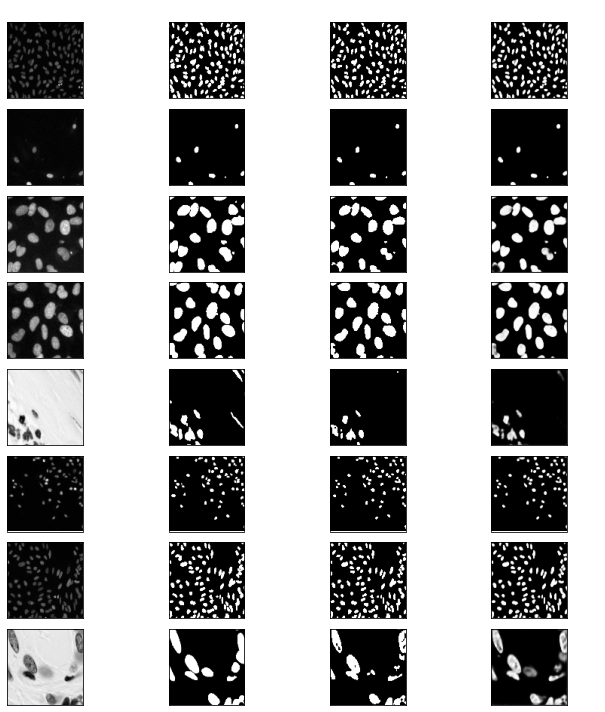

In [44]:
# Visualizing some samples with segmentation
num_samples = 8
shift = 0 # To plot other samples
fig, ax = plt.subplots(num_samples, 4, figsize=(10, 10))

params = {"top": False, "bottom": False, "left": False, "right": False, "labelleft": False,
          "labelbottom": False}

# Set column label color
# mpl.rcParams["axes.titlecolor"] = "white"
# mpl.rcParams["axes.labelcolor"] = "white"
# mpl.rcParams["text.color"] = "white"

ax[0, 0].title.set_text("Original")
ax[0, 1].title.set_text("Ground Truth")
ax[0, 2].title.set_text("Prediction - binarized")
ax[0, 3].title.set_text("Prediction - continuous")

for i in range(0, num_samples):
    ax[i, 0].imshow(test_imgs_plotting[i+shift], cmap="gray")
    ax[i, 0].tick_params(**params)
    ax[i, 1].imshow(test_masks_plotting[i+shift], cmap="gray")
    ax[i, 1].tick_params(**params)
    ax[i, 2].imshow(pred_binary[i+shift], cmap="gray")
    ax[i, 2].tick_params(**params)
    ax[i, 3].imshow(pred_plotting[i+shift], cmap="gray")
    ax[i, 3].tick_params(**params)

plt.tight_layout()
plt.show()

In [29]:
# IoU and DICE at multiple thresholds
test_results = pd.DataFrame(columns=["Threshold", "IoU", "Dice"])

thresholds = np.arange(0, 1, 0.1)
ious = []
dices = []

for i in thresholds:
    iou = iou1class(test_masks, pred, threshold=i)
    ious.append(iou)
    dices.append(iou2dice(iou))

test_results["Threshold"] = thresholds
test_results["IoU"] = np.round(ious, 2)
test_results["Dice"] = np.round(dices, 2)

test_results

,Threshold,IoU,Dice
0,0.0,0.16,0.27
1,0.1,0.75,0.85
2,0.2,0.76,0.86
3,0.3,0.75,0.86
4,0.4,0.74,0.85
5,0.5,0.72,0.84
6,0.6,0.69,0.82
7,0.7,0.65,0.79
8,0.8,0.59,0.74
9,0.9,0.47,0.64
